In [1]:
from montecarlo import MonteCarlo
from CIRModel import BasicCIRModel
from ECIRModel import ECIRModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_data(years):
    z = pd.read_csv('zero_coupon_yields_'+str(years)+'.csv')
    z = z.set_index('DATE')
    z = z.loc['2018-12-15':'2023-12-14']
    return z

z = pd.DataFrame()
years = [1, 2, 3, 5, 7, 10, 20, 30]

for i in years:
    z[i] = read_data(i)
    z[i] = z[i].replace('.', np.nan)
    z[i] = pd.to_numeric(z[i])

z = z.dropna()

In [3]:
def create_model(mod, data):
    models = []
    for i in data:
        models.append(MonteCarlo(mod, data[i][0]/100, int(i), 365*int(i), 100))

    return models

In [10]:
# Assuming you already have the BasicCIRModel defined correctly
cir = create_model(BasicCIRModel(0.3, 0.04, 3), z)

# Updated ECIRModel instantiation with all parameters
ecir = create_model(ECIRModel(kappa=0.01227, mu_r=0.09854, sigma=0.09395, r=66, p=0.3049, mu=0.002995, gamma=0.002321), z)


/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_97700/2746386555.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  models.append(MonteCarlo(mod, data[i][0]/100, int(i), 365*int(i), 100))


In [11]:
prices_cir = pd.DataFrame()
for model in cir:
    prices_cir[model] = model.price_estimates()[2]

prices_cir.columns = years

In [12]:
prices_ecir = pd.DataFrame()
for model in ecir:
    prices_ecir[model] = model.price_estimates()[2]

prices_ecir.columns = years

In [13]:
prices = pd.concat([prices_cir, prices_ecir], axis = 1)
prices = prices.sort_index(axis = 1)
cols = ['1_CIR', '1_ECIR', '2_CIR', '2_ECIR', '3_CIR', '3_ECIR', '5_CIR', '5_ECIR', '7_CIR', '7_ECIR','10_CIR', '10_ECIR', '20_CIR', '20_ECIR', '30_CIR', '30_ECIR']
prices.columns = cols

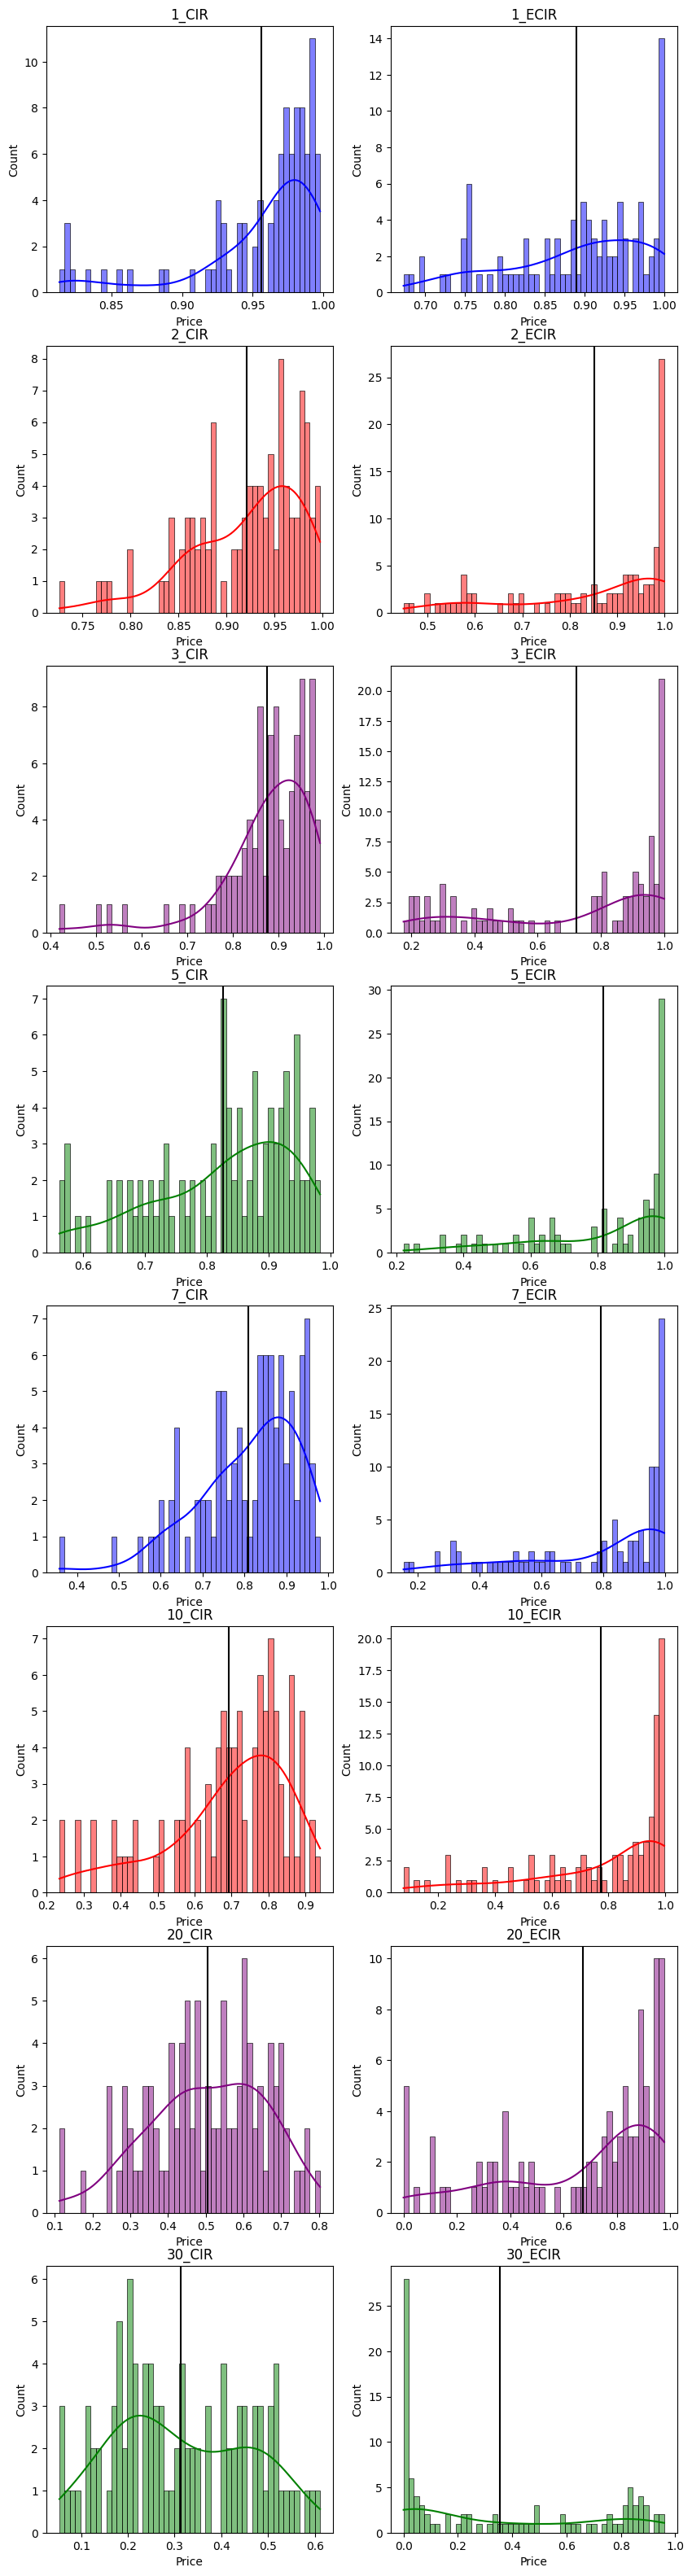

In [14]:
colors = ['blue', 'blue', 'red', 'red', 'purple', 'purple', 'green', 'green']*2

plt.figure(figsize = (10, 40))
for i in range(len(prices.columns)):
    plt.subplot(8, 2, i+1)
    plt.title(prices.columns.to_list()[i])
    sns.histplot(prices[cols[i]], color = colors[i], bins = 50, kde = True)
    plt.xlabel('Price')
    plt.axvline(np.mean(prices[cols[i]]), color = 'black')



In [15]:
avg_cir = []
err_cir = []
for col in prices_cir:
    avg_cir.append(np.mean(prices_cir[col]))
    err_cir.append(np.std(prices_cir[col]))

avg_ecir = []
err_ecir = []
for col in prices_ecir:
    avg_ecir.append(np.mean(prices_ecir[col]))
    err_ecir.append(np.std(prices_ecir[col]))

Text(0, 0.5, 'Price')

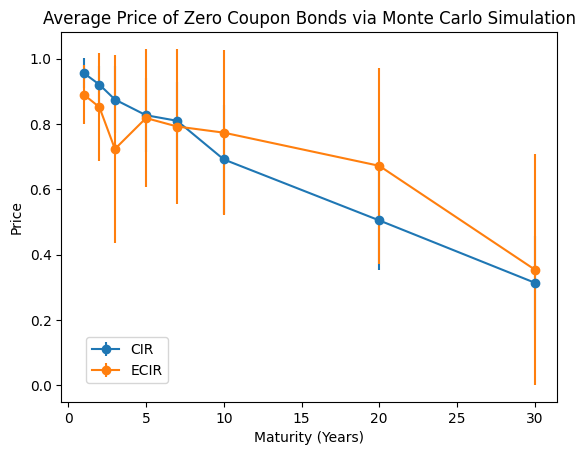

In [16]:
plt.errorbar(years, avg_cir, yerr = err_cir, label = 'CIR', marker = 'o')
plt.errorbar(years, avg_ecir, yerr = err_ecir, label = 'ECIR', marker = 'o')
plt.legend(loc = (0.05, 0.05))
plt.title('Average Price of Zero Coupon Bonds via Monte Carlo Simulation')
plt.xlabel('Maturity (Years)')
plt.ylabel('Price')

In [17]:
cir_paths = pd.DataFrame()

for i in range(len(cir)):
    cir_paths[years[i]] = cir[i].paths()

In [18]:
ecir_paths = pd.DataFrame()

for i in range(len(ecir)):
    ecir_paths[years[i]] = ecir[i].paths()

In [19]:
paths = pd.concat([cir_paths, ecir_paths], axis = 1)
paths = paths.sort_index(axis = 1)
cols = ['1_CIR', '1_ECIR', '2_CIR', '2_ECIR', '3_CIR', '3_ECIR', '5_CIR', '5_ECIR', '7_CIR', '7_ECIR','10_CIR', '10_ECIR', '20_CIR', '20_ECIR', '30_CIR', '30_ECIR']
paths.columns = cols

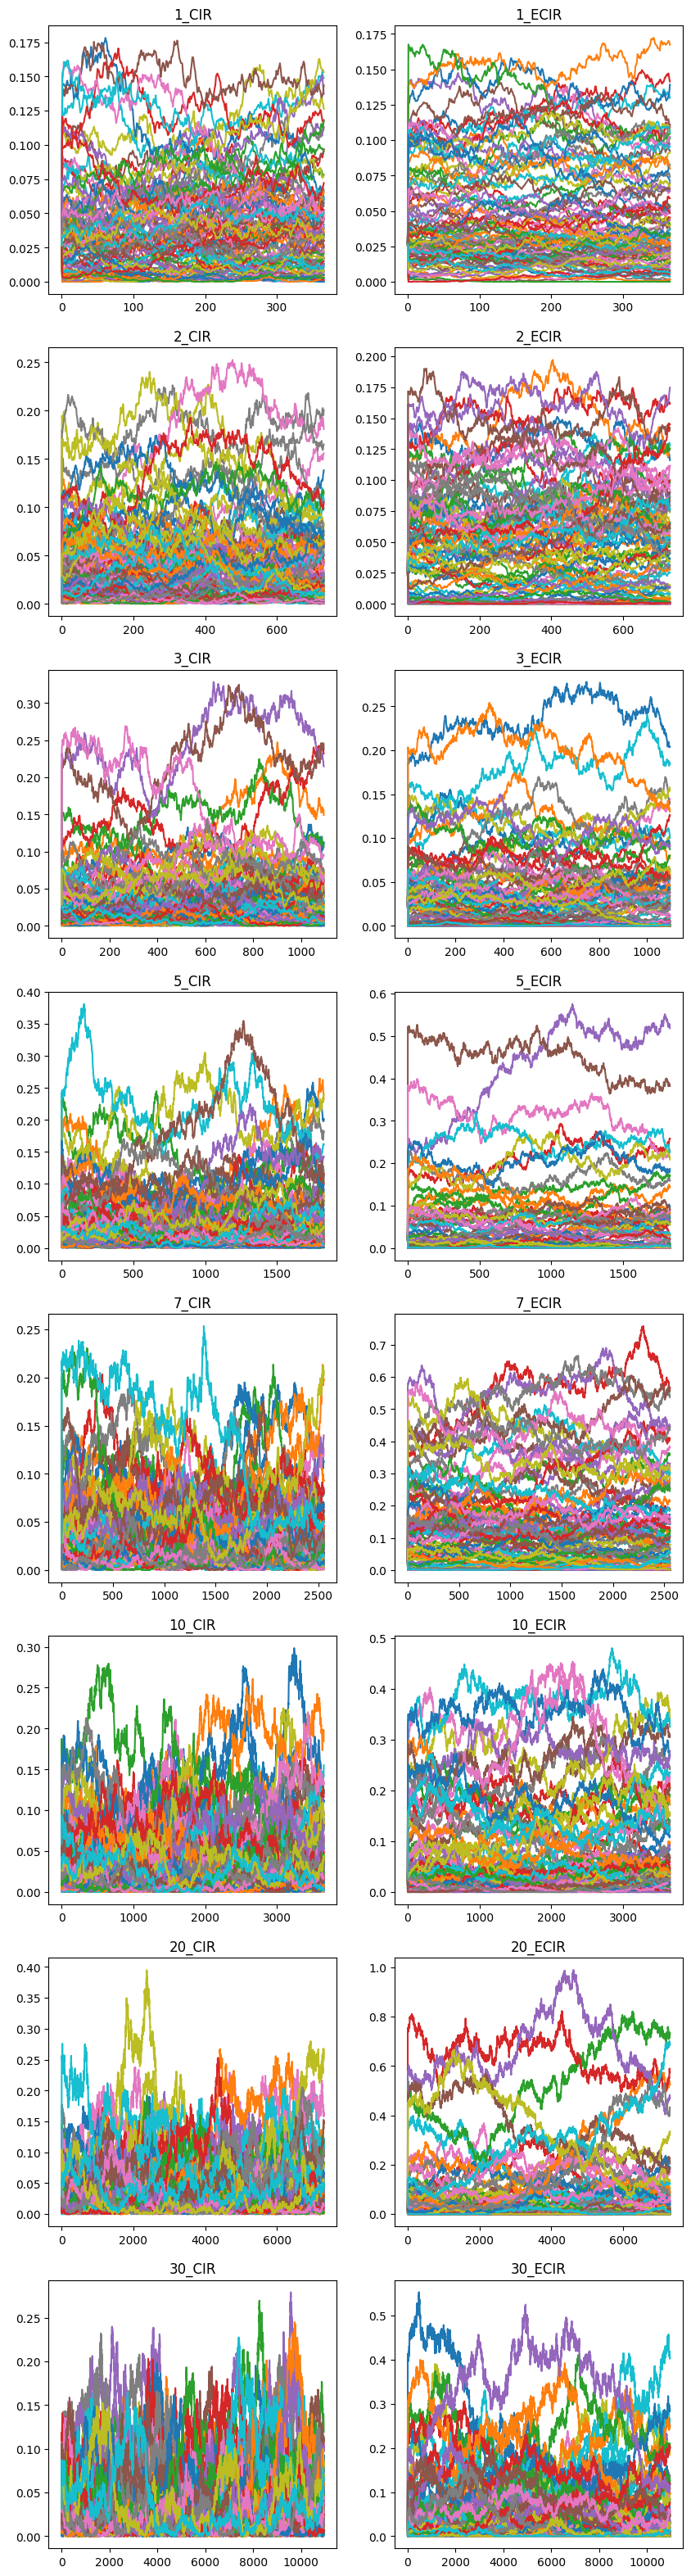

In [20]:
plt.figure(figsize = (10, 40))
for i in range(len(cols)):
    plt.subplot(8, 2, i+1)
    plt.title(cols[i])
    for j in range(len(paths[cols[i]])):
        plt.plot(np.arange(0, len(paths[cols[i]][j])), paths[cols[i]][j])

In [21]:
term = pd.DataFrame()
for i in range(len(cols)):
    term_val = []
    for j in range(len(paths[cols[i]])):
        term_val.append(paths[cols[i]][j][-1])
    term[cols[i]] = term_val

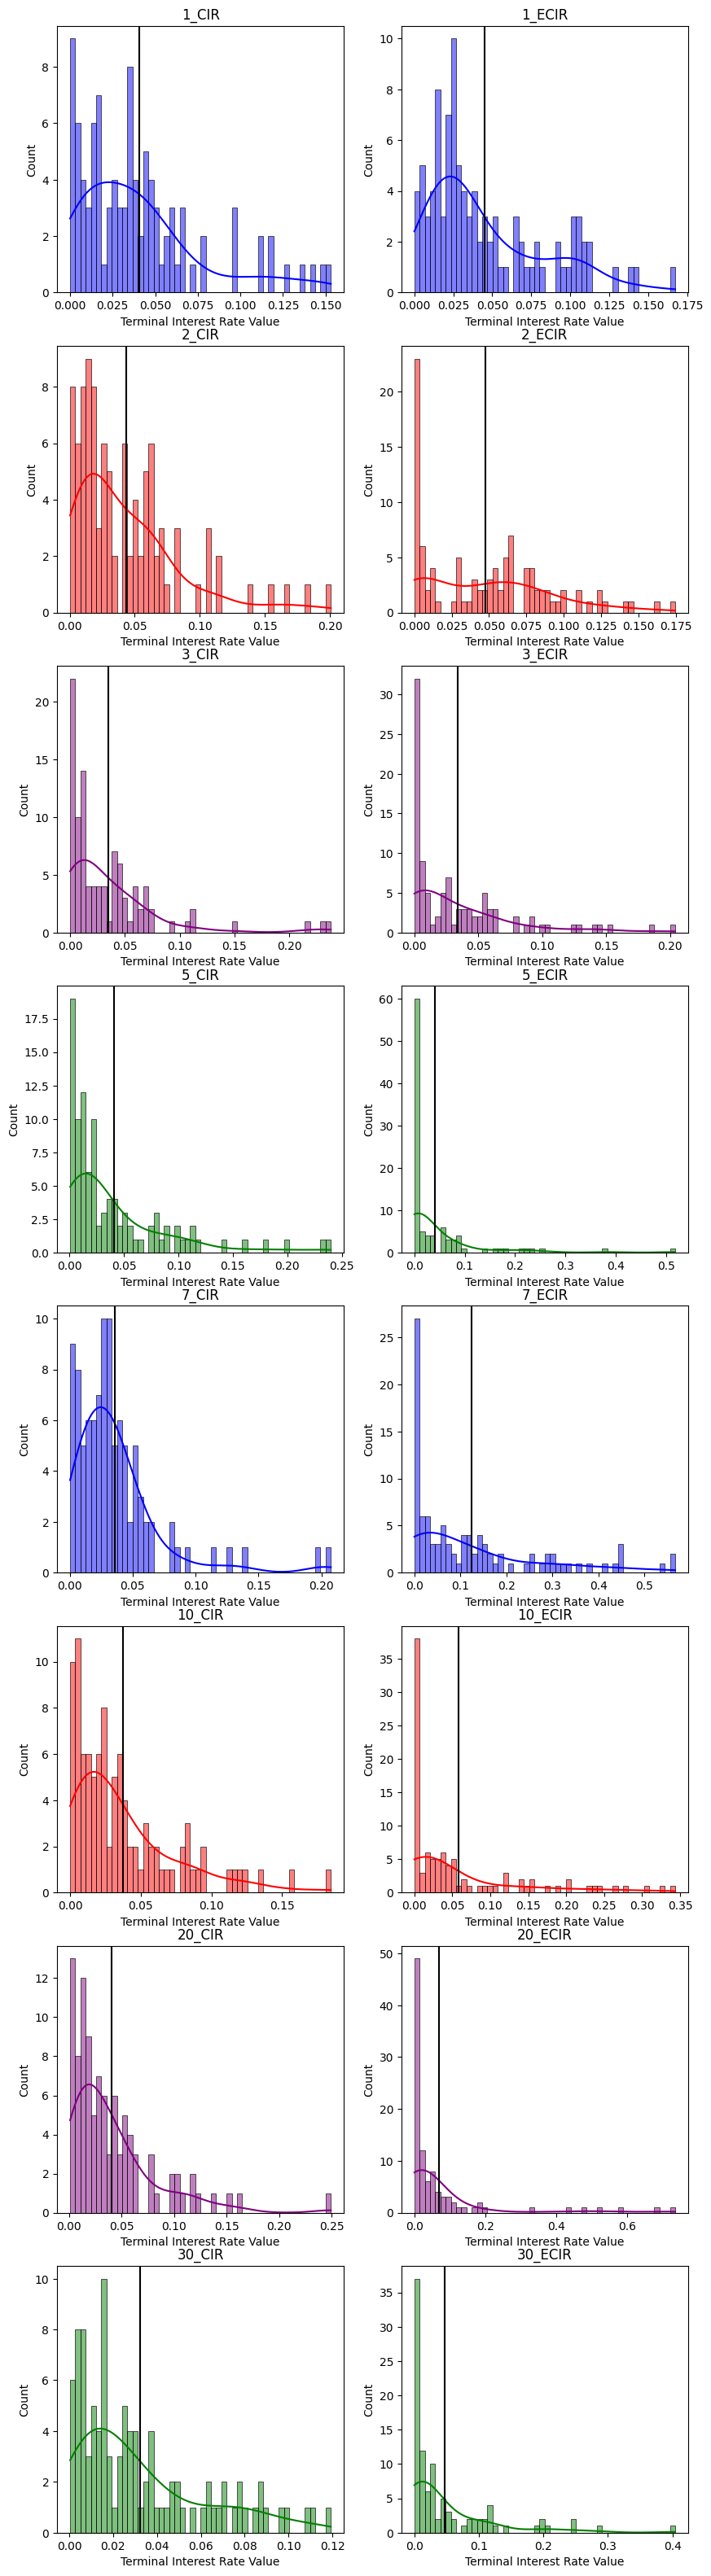

In [22]:
plt.figure(figsize = (10, 40))
for i in range(len(cols)):
    plt.subplot(8, 2, i+1)
    plt.title(cols[i])
    sns.histplot(term[cols[i]], color = colors[i], bins = 50, kde = True)
    plt.xlabel('Terminal Interest Rate Value')
    plt.axvline(np.mean(term[cols[i]]), color = 'black')

In [23]:
term_cir = pd.DataFrame()
term_ecir = pd.DataFrame()
for i in range(len(cols)):
    if i%2 == 0:
        term_cir[cols[i]]  = term[cols[i]]
    else:
        term_ecir[cols[i]] = term[cols[i]]

In [24]:
avg_cir_term = []
err_cir_term = []
for col in term_cir:
    avg_cir_term.append(np.mean(term_cir[col]))
    err_cir_term.append(np.std(term_cir[col]))

avg_ecir_term = []
err_ecir_term = []
for col in term_ecir:
    avg_ecir_term.append(np.mean(term_ecir[col]))
    err_ecir_term.append(np.std(term_ecir[col]))

Text(0, 0.5, 'Terminal Value of Interest Rate')

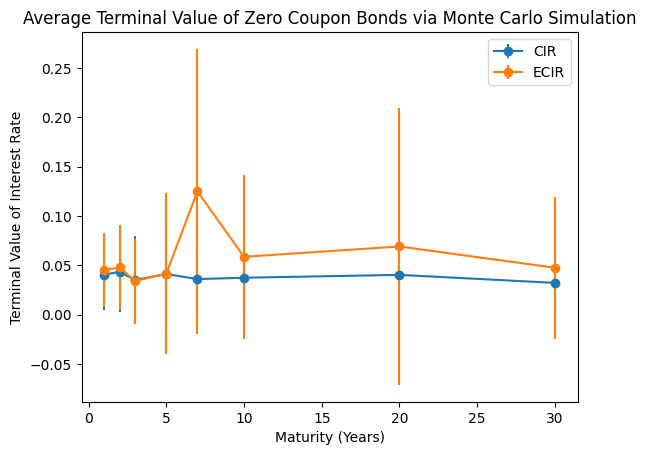

In [25]:
plt.errorbar(years, avg_cir_term, yerr = err_cir_term, label = 'CIR', marker = 'o')
plt.errorbar(years, avg_ecir_term, yerr = err_ecir_term, label = 'ECIR', marker = 'o')
plt.legend()
plt.title('Average Terminal Value of Zero Coupon Bonds via Monte Carlo Simulation')
plt.xlabel('Maturity (Years)')
plt.ylabel('Terminal Value of Interest Rate')

## Standard Deviation- Yield Rates Estimates

In [36]:
import pandas as pd

# Define maturities and model names based on your provided list
maturities = ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
model_names = ['CIR', 'ECIR']

# Prepare data for DataFrame with zeros, to be replaced by actual standard deviations
data = {maturity: [0] * len(model_names) for maturity in maturities}
sd_df = pd.DataFrame(data, index=model_names)

# Populate the DataFrame with standard deviations for CIR and ECIR
for i, col in enumerate(term_cir.columns):
    # Assuming term_cir columns are ordered by maturity as '1', '2', '3', ..., '30'
    maturity = maturities[i]  # Convert numerical index to maturity string
    sd_df.loc['CIR', maturity] = term_cir[col].std()  # Insert CIR std dev

for i, col in enumerate(term_ecir.columns):
    # Assuming term_ecir columns are ordered by maturity as '1', '2', '3', ..., '30'
    maturity = maturities[i]  # Convert numerical index to maturity string
    sd_df.loc['ECIR', maturity] = term_ecir[col].std()  # Insert ECIR std dev

# The resulting DataFrame has models as index and maturities as columns
print(sd_df)


            1Y        2Y        3Y        5Y        7Y       10Y       20Y  \
CIR   0.036497  0.040874  0.045036  0.050217  0.035332  0.037192  0.041560   
ECIR  0.037486  0.042779  0.043251  0.082100  0.145003  0.083322  0.140895   

           30Y  
CIR   0.029444  
ECIR  0.072116  


/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_97700/4188028806.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03649698751815385' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sd_df.loc['CIR', maturity] = term_cir[col].std()  # Insert CIR std dev
/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_97700/4188028806.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.04087427980212764' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sd_df.loc['CIR', maturity] = term_cir[col].std()  # Insert CIR std dev
/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_97700/4188028806.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.

## Standard Deviation——Bond Price Estimates

In [38]:
import pandas as pd

# Define maturities and model names based on your provided list
maturities = ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
model_names = ['CIR', 'ECIR']

# Prepare data for DataFrame with zeros, to be replaced by actual standard deviations
data = {maturity: [0] * len(model_names) for maturity in maturities}
sd_df = pd.DataFrame(data, index=model_names)

# Populate the DataFrame with standard deviations for CIR and ECIR
for i, col in enumerate(prices_cir.columns):
    # Assuming term_cir columns are ordered by maturity as '1', '2', '3', ..., '30'
    maturity = maturities[i]  # Convert numerical index to maturity string
    sd_df.loc['CIR', maturity] = prices_cir[col].std()  # Insert CIR std dev

for i, col in enumerate(prices_ecir.columns):
    # Assuming term_ecir columns are ordered by maturity as '1', '2', '3', ..., '30'
    maturity = maturities[i]  # Convert numerical index to maturity string
    sd_df.loc['ECIR', maturity] =prices_ecir[col].std()  # Insert ECIR std dev

# The resulting DataFrame has models as index and maturities as columns
print(sd_df)


            1Y        2Y        3Y        5Y        7Y       10Y       20Y  \
CIR   0.046292  0.058750  0.104466  0.113581  0.120349  0.167194  0.153437   
ECIR  0.089594  0.165425  0.289222  0.212492  0.238957  0.254549  0.301013   

           30Y  
CIR   0.145244  
ECIR  0.355343  


/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_97700/2687707075.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.04629167681321094' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sd_df.loc['CIR', maturity] = prices_cir[col].std()  # Insert CIR std dev
/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_97700/2687707075.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05874956100825784' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sd_df.loc['CIR', maturity] = prices_cir[col].std()  # Insert CIR std dev
/var/folders/xw/z6_zcc7n7874ly2ljw7m9dk800ddy1/T/ipykernel_97700/2687707075.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value

In [118]:
# import pandas as pd

# # Load the CSV file into a DataFrame
# df = pd.read_csv('DGS_30.csv')

# # Set the first column as the index assuming it's the date
# df.set_index(df.columns[0], inplace=True)

# # Define the face value for the bond price calculations
# face_value = 100

# # Calculate actual bond prices from the yield rates provided in the CSV
# # Assuming a zero-coupon bond for simplicity
# actual_prices = pd.DataFrame()
# for col in df.columns:
#     maturity_years = int(col.replace('DGS', ''))
#     # Convert the annual yield rate into a bond price
#     actual_prices[col] = face_value / ((1 + df[col]/100) ** maturity_years)

# # We already have rates, just need to copy them
# actual_rates = df.copy()

# # Preview the first few rows of the actual prices and rates
# actual_prices.head(), actual_rates.head()


In [117]:
#print(prices_ecir)

In [116]:
#print(term_cir)
#print(term_ecir)

## Mean Absolute Error-Yield Rates

In [105]:

df = pd.read_csv('DGS_30.csv')

# Extract the relevant columns for the specified maturities
maturities = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
actual_rates_selected = df[maturities]

# Calculate the average rate for each maturity to use as actual rates
actual_rates_mean = 0.1*actual_rates_selected.mean()
estimated_rates_cir=term_cir.mean()
estimated_rates_ecir=term_ecir.mean()


# Rename the columns of the estimated rates DataFrames to match the actual rates DataFrame for direct comparison
estimated_rates_cir.index = ['DGS' + idx.split('_')[0] for idx in estimated_rates_cir.index]
estimated_rates_ecir.index = ['DGS' + idx.split('_')[0] for idx in estimated_rates_ecir.index]

# Calculate the MAE for each term
mae_rates_cir = abs(actual_rates_mean - estimated_rates_cir)
mae_rates_ecir = abs(actual_rates_mean - estimated_rates_ecir)

# Create a DataFrame to display the MAE for each term for CIR and ECIR models
mae_rates_df = pd.DataFrame({'CIR': mae_rates_cir, 'ECIR': mae_rates_ecir})

# Transpose the DataFrame so that models are in rows and terms are in columns
mae_rates_df = mae_rates_df.T

# Ensure the column names match the original maturities list for display
mae_rates_df.columns = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']

# Display the DataFrame
mae_rates_df


,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
CIR,0.101519,0.054616,0.052815,0.002166,0.043902,0.077459,0.076965,0.100404
ECIR,0.072150,0.087163,0.020563,0.016147,0.042545,0.010915,0.063991,0.087333


## Mean Absolute Error-Bond Price

In [108]:
import pandas as pd
import numpy as np

df = pd.read_csv('DGS_30.csv')

# 提取相关列
maturities = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
actual_rates_selected = df[maturities]

# 计算每个到期日的平均利率
actual_rates_mean = 0.1 * actual_rates_selected.mean()

# 假设面值
face_value = 100
# 实际的到期年数
years_to_maturity = [1, 2, 3, 5, 7, 10, 20, 30]

# 计算实际利率下的债券价格
actual_bond_prices = face_value / ((1 + actual_rates_mean / 100) ** years_to_maturity)

# 估计的债券价格（CIR和ECIR），这里假设estimated_rates_cir和estimated_rates_ecir是Series并且索引已经匹配
estimated_bond_prices_cir = face_value / ((1 + estimated_rates_cir / 100) ** years_to_maturity)
estimated_bond_prices_ecir = face_value / ((1 + estimated_rates_ecir / 100) ** years_to_maturity)

# 计算MAE
mae_bond_prices_cir = abs(actual_bond_prices - estimated_bond_prices_cir)
mae_bond_prices_ecir = abs(actual_bond_prices - estimated_bond_prices_ecir)

# 创建DataFrame展示每个模型的MAE
mae_bond_prices_df = pd.DataFrame({'CIR': mae_bond_prices_cir, 'ECIR': mae_bond_prices_ecir}, index=maturities)

# 转置DataFrame，使模型在行中，条款在列中
mae_bond_prices_df = mae_bond_prices_df.T

# 显示DataFrame
print(mae_bond_prices_df)


          DGS1      DGS2      DGS3      DGS5      DGS7     DGS10     DGS20  \
CIR   0.100582  0.107699  0.155374  0.010514  0.295255  0.732952  1.379747   
ECIR  0.071505  0.171796  0.060533  0.078329  0.285145  0.102784  1.145609   

         DGS30  
CIR   2.553215  
ECIR  2.216345  


## Mean Absolute Error

In [115]:


# Now we can calculate the MAE properly since the indices match
mae_rates_cir = (abs(actual_rates_mean - estimated_rates_cir)).mean()
mae_rates_ecir = (abs(actual_rates_mean - estimated_rates_ecir)).mean()
mae_bond_prices_cir = abs(actual_bond_prices - estimated_bond_prices_cir).mean()
mae_bond_prices_ecir = abs(actual_bond_prices - estimated_bond_prices_ecir).mean()

# Create a DataFrame to display the MAE for yield rate estimates
# 创建一个 DataFrame 来展示收益率估计和债券价格的 MAE
mae_df = pd.DataFrame({
    'CIR': [mae_rates_cir, mae_bond_prices_cir],
    'ECIR': [mae_rates_ecir, mae_bond_prices_ecir]
}, index=['Yield Rate Estimates', 'Bond Prices MAE'])

# 转置 DataFrame 以匹配请求的格式
mae_df = mae_df.T

# 显示 DataFrame
print(mae_df)


# Transpose the DataFrame to match the requested format
#mae_rates_df = mae_rates_df.T

# Display the DataFrame
#mae_rates_df




      Yield Rate Estimates  Bond Prices MAE
CIR               0.063731         0.666917
ECIR              0.050101         0.516506
